Cluster -1.0: 188 variable stars, average distance: 7813.23 parsecs, uncertainty: 61.52 parsecs
Cluster 0.0: 38 variable stars, average distance: 18148.85 parsecs, uncertainty: 137.79 parsecs
Cluster 1.0: 34 variable stars, average distance: 19531.87 parsecs, uncertainty: 147.78 parsecs
Cluster 2.0: 49 variable stars, average distance: 20163.84 parsecs, uncertainty: 152.31 parsecs
Cluster 3.0: 47 variable stars, average distance: 18752.82 parsecs, uncertainty: 143.22 parsecs
Cluster 4.0: 52 variable stars, average distance: 18449.80 parsecs, uncertainty: 139.99 parsecs
Cluster 5.0: 41 variable stars, average distance: 17096.08 parsecs, uncertainty: 129.71 parsecs
Cluster 6.0: 63 variable stars, average distance: 25709.92 parsecs, uncertainty: 195.56 parsecs
Cluster 7.0: 44 variable stars, average distance: 27107.67 parsecs, uncertainty: 209.17 parsecs
Cluster 8.0: 44 variable stars, average distance: 18726.17 parsecs, uncertainty: 143.62 parsecs
Cluster 9.0: 7 variable stars, average d

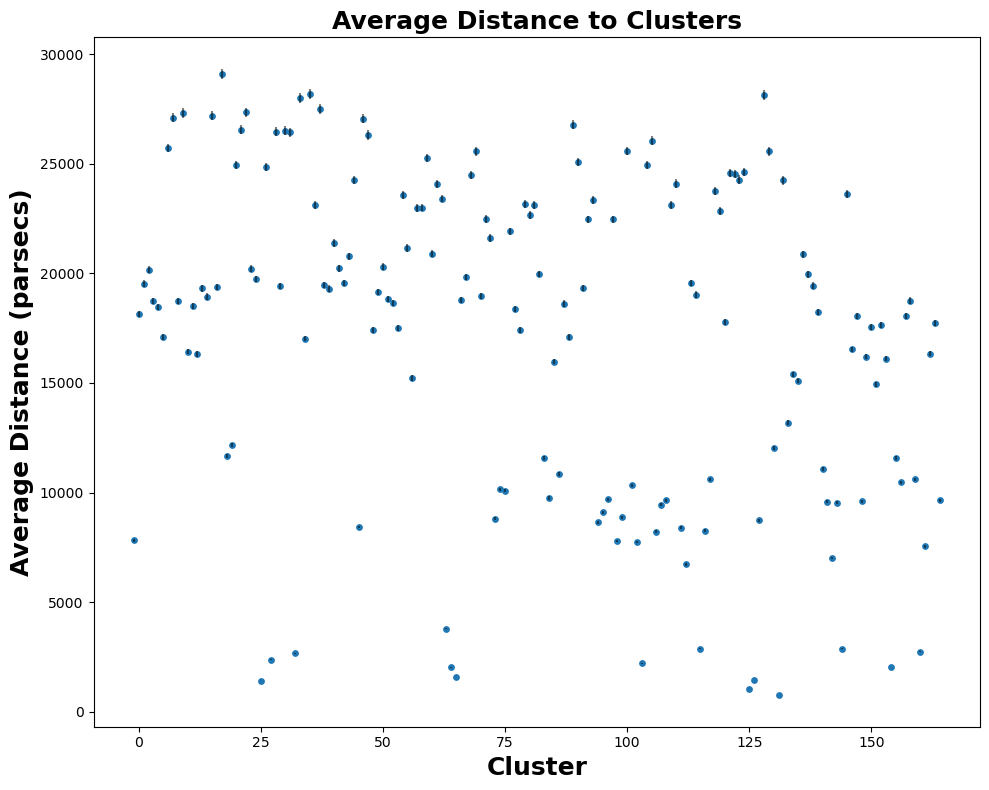

Number of variable stars, average distance, and uncertainty for each cluster:
Cluster -1.0: 188 variable stars, average distance: 7813.23 parsecs, uncertainty: 61.52 parsecs
Cluster 0.0: 38 variable stars, average distance: 18148.85 parsecs, uncertainty: 137.79 parsecs
Cluster 1.0: 34 variable stars, average distance: 19531.87 parsecs, uncertainty: 147.78 parsecs
Cluster 2.0: 49 variable stars, average distance: 20163.84 parsecs, uncertainty: 152.31 parsecs
Cluster 3.0: 47 variable stars, average distance: 18752.82 parsecs, uncertainty: 143.22 parsecs
Cluster 4.0: 52 variable stars, average distance: 18449.80 parsecs, uncertainty: 139.99 parsecs
Cluster 5.0: 41 variable stars, average distance: 17096.08 parsecs, uncertainty: 129.71 parsecs
Cluster 6.0: 63 variable stars, average distance: 25709.92 parsecs, uncertainty: 195.56 parsecs
Cluster 7.0: 44 variable stars, average distance: 27107.67 parsecs, uncertainty: 209.17 parsecs
Cluster 8.0: 44 variable stars, average distance: 18726.17

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os

# Load Converted Star Data csv

star_data = pd.read_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/clustered_star_data.csv')

# Function to plot the light curve with the calculated period
def plot_light_curve(star_id, period, fap, is_included):
    var_data = pd.read_csv(f'/Users/kobibrown/Desktop/Distance_Ladder_Project/Variable_Star_Data/{star_id}.csv')
    time = var_data['Time']
    flux = var_data['NormalisedFlux']

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(time, flux, '.', markersize=4)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Normalized Flux')

    if is_included:
        ax.set_title(f'Star ID: {star_id} | Period: {period:.2f} hours | FAP: {fap:.4f} (Included)')
    else:
        ax.set_title(f'Star ID: {star_id} | Period: {period:.2f} hours | FAP: {fap:.4f} (Omitted)')

    # Plot red lines to show the calculated period
    min_time, max_time = min(time), max(time)
    num_periods = int((max_time - min_time) / period)
    for i in range(num_periods + 1):
        ax.axvline(min_time + i * period, color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()

    # Create the output directory
    output_dir = '/Users/kobibrown/Desktop/Distance_Ladder_Project/Variable_Star_Light_Curves'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    plt.savefig(f'{output_dir}/{star_id}_light_curve.png')
    plt.close()

#Function to get periods and FAP score
def get_period_and_fap(star_id):
    var_data = pd.read_csv(f'/Users/kobibrown/Desktop/Distance_Ladder_Project/Variable_Star_Data/{star_id}.csv')

    time = var_data['Time']
    flux = var_data['NormalisedFlux']

    frequency, power = LombScargle(time, flux).autopower(method='fast', nyquist_factor=1)
    max_power_idx = np.argmax(power)
    best_frequency = frequency[max_power_idx]

    period = 1 / best_frequency
    fap = LombScargle(time, flux).false_alarm_probability(power[max_power_idx])

    return period, fap

fap_threshold = 0.05  # sig level

# distance calculations
def calc_distance(period, starflux):
    if period < 30:
        # Use short period variable relationship
        dist = 10**(((period*0.08 - 9.80) - ((np.log10(starflux)))) / 2 )
        absoluteflux = period*0.08 - 9.80
    else:
        # Use long period variable relationship
        dist = 10**(((period*0.06 - 7.73) - ((np.log10(starflux)))) / 2 )
        absoluteflux = period*0.06 - 7.73
    return dist, absoluteflux

# Specify which flux band for analysis
band = 'Green'

# Iterate over all clusters
cluster_distances = []
cluster_distance_uncertainties = []
for cluster in sorted(star_data['cluster'].unique()):
    # Filter the variable stars (Variable? == 1) in the current cluster
    variable_stars = star_data[(star_data['cluster'] == cluster) & (star_data['Variable?'] == 1)]['Name']
    distances = []
    distance_uncertainties = []

    # Calculate the distance to each variable star
    for star_id in variable_stars:
        try:
            period, fap = get_period_and_fap(star_id)
            is_included = False
            if fap < fap_threshold:
                parallax = star_data.loc[star_data['Name'] == star_id, 'Parallax'].values[0]

                if parallax > 0.005:
                    # Use parallax to calculate the distance in parsecs
                    distance = 1 / parallax

                    # Calculate uncertainty in distance measurement
                    parallax_error = 0.001  # given
                    d_distance = abs(distance**2 * parallax_error)
                else:
                    starflux = star_data.loc[star_data['Name'] == star_id, f'{band}F'].values[0]
                    distance, absoluteflux = calc_distance(period, starflux)

                    # Calculate uncertainty in distance measurement
                    d_period = 0.3  #given
                    d_absoluteflux = 0.15  #given
                    d_distance = distance * np.sqrt((d_period * 0.434 / period)**2 + (d_absoluteflux / (2 * 2.17 * absoluteflux))**2)

                distances.append(distance)
                distance_uncertainties.append(d_distance)
                is_included = True
            plot_light_curve(star_id, period, fap, is_included)
        except FileNotFoundError:
            continue

    # Compute the average distance and uncertainty for all variable stars in the cluster
    if len(distances) > 0:
        avg_distance = np.mean(distances)
        avg_distance_uncertainty = np.mean(distance_uncertainties)
        cluster_distances.append((cluster, avg_distance))
        cluster_distance_uncertainties.append((cluster, avg_distance_uncertainty))
    else:
        cluster_distances.append((cluster, np.nan))
        cluster_distance_uncertainties.append((cluster, np.nan))
        
# Save the cluster distances and uncertainties in new DataFrames and export them as CSV files
cluster_distances_df = pd.DataFrame(cluster_distances, columns=['Cluster', 'Distance (parsecs)'])
cluster_distances_df.to_csv('cluster_distances.csv', index=False)

cluster_distance_uncertainties_df = pd.DataFrame(cluster_distance_uncertainties, columns=['Cluster', 'Distance Uncertainty (parsecs)'])
cluster_distance_uncertainties_df.to_csv('cluster_distance_uncertainties.csv', index=False)

# Iterate over rows of the cluster_distances_df DataFrame
for index, row in cluster_distances_df.iterrows():
    cluster = row['Cluster']
    avg_distance = row['Distance (parsecs)']
    std_distance = cluster_distance_uncertainties_df.loc[cluster_distance_uncertainties_df['Cluster'] == cluster, 'Distance Uncertainty (parsecs)'].values[0]
    num_variable_stars = len(star_data[(star_data['cluster'] == cluster) & (star_data['Variable?'] == 1)]['Name'])
    print(f"Cluster {cluster}: {num_variable_stars} variable stars, average distance: {avg_distance:.2f} parsecs, uncertainty: {std_distance:.2f} parsecs")

# Plot the distribution of distances for each cluster
plt.figure(figsize=(10, 8))
plt.scatter(cluster_distances_df['Cluster'], cluster_distances_df['Distance (parsecs)'], s=15)
plt.errorbar(cluster_distances_df['Cluster'], cluster_distances_df['Distance (parsecs)'], yerr=cluster_distance_uncertainties_df['Distance Uncertainty (parsecs)'], fmt='none', ecolor='black', alpha=0.5)
plt.xlabel('Cluster', fontsize=18, fontweight='bold')
plt.ylabel('Average Distance (parsecs)', fontsize=18, fontweight='bold')
plt.title('Average Distance to Clusters', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Print the number of variable stars, average distance, and uncertainty for each cluster
print("Number of variable stars, average distance, and uncertainty for each cluster:")
for index, row in cluster_distances_df.iterrows():
    cluster = row['Cluster']
    avg_distance = row['Distance (parsecs)']
    std_distance = cluster_distance_uncertainties_df.loc[cluster_distance_uncertainties_df['Cluster'] == cluster, 'Distance Uncertainty (parsecs)'].values[0]
    num_variable_stars = len(star_data[(star_data['cluster'] == cluster) & (star_data['Variable?'] == 1)]['Name'])
    print(f"Cluster {cluster}: {num_variable_stars} variable stars, average distance: {avg_distance:.2f} parsecs, uncertainty: {std_distance:.2f} parsecs")
    
    # Add a new column 'Distance' and 'Distance Uncertainty' to the original DataFrame
star_data['Distance'] = np.nan
star_data['Distance Uncertainty'] = np.nan

# Fill in the distance values and uncertainties for each star in their respective clusters
for cluster, avg_distance in cluster_distances:
    variable_stars = star_data[(star_data['cluster'] == cluster) & (star_data['Variable?'] == 1)]
    distances = []
    for _, star in variable_stars.iterrows():
        star_id = star['Name']
        try:
            period, fap = get_period_and_fap(star_id)
            if fap < fap_threshold:
                starflux = star[f'{band}F']
                distance, absoluteflux = calc_distance(period, starflux)
                distances.append(distance)
        except FileNotFoundError:
            continue
    if len(distances) > 0:
        avg_distance = np.mean(distances)
        dist_uncertainty = np.std(distances) / np.sqrt(len(distances))
        star_data.loc[star_data['cluster'] == cluster, 'Distance'] = avg_distance
        star_data.loc[star_data['cluster'] == cluster, 'Distance Uncertainty'] = dist_uncertainty

# Export the updated DataFrame to a new CSV file
star_data.to_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/clustered_star_data_with_distances.csv', index=False)


In [25]:
# Fill in the distance values and uncertainties for each star in their respective clusters
for cluster, avg_distance in cluster_distances:
    stars = star_data[star_data['cluster'] == cluster]
    variable_stars = stars[stars['Variable?'] == 1]
    
    # Calculate distances and uncertainties for variable stars
    for _, star in variable_stars.iterrows():
        star_id = star['Name']
        try:
            period, fap = get_period_and_fap(star_id)
            if fap < fap_threshold:
                parallax = star_data.loc[star_data['Name'] == star_id, 'Parallax'].values[0]
                if parallax > 0.005:
                    # Use parallax to calculate the distance in parsecs
                    distance = 1 / parallax

                    # Calculate uncertainty in distance measurement
                    parallax_error = 0.001  # constant uncertainty value
                    d_distance = abs(distance**2 * parallax_error)

                    # Update distance and distance uncertainty for the current star
                    star_data.loc[star_data['Name'] == star_id, 'Distance'] = distance
                    star_data.loc[star_data['Name'] == star_id, 'Distance Uncertainty'] = d_distance

                else:
                    starflux = star[f'{band}F']
                    distance, absoluteflux = calc_distance(period, starflux)
                    distances.append(distance)
        except FileNotFoundError:
            continue

    # Calculate average distance and uncertainty for non-variable stars that couldn't be measured using parallax or period-luminosity relation
    distances = []
    for _, star in stars.iterrows():
        star_id = star['Name']
        if pd.isna(star['Distance']) and star['Variable?'] == 0:
            starflux = star[f'{band}F']
            distance, absoluteflux = calc_distance(period, starflux)
            distances.append(distance)
    
    if len(distances) > 0:
        avg_distance = np.mean(distances)
        dist_uncertainty = np.std(distances) / np.sqrt(len(distances))
    
    # Update distance and distance uncertainty for non-variable stars that couldn't be measured using parallax or period-luminosity relation
    for _, star in stars.iterrows():
        star_id = star['Name']
        if pd.isna(star['Distance']) and star['Variable?'] == 0:
            star_data.loc[star_data['Name'] == star_id, 'Distance'] = avg_distance
            star_data.loc[star_data['Name'] == star_id, 'Distance Uncertainty'] = dist_uncertainty

# Export the updated DataFrame to a new CSV file
star_data.to_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/clustered_star_data_with_distances.csv', index=False)

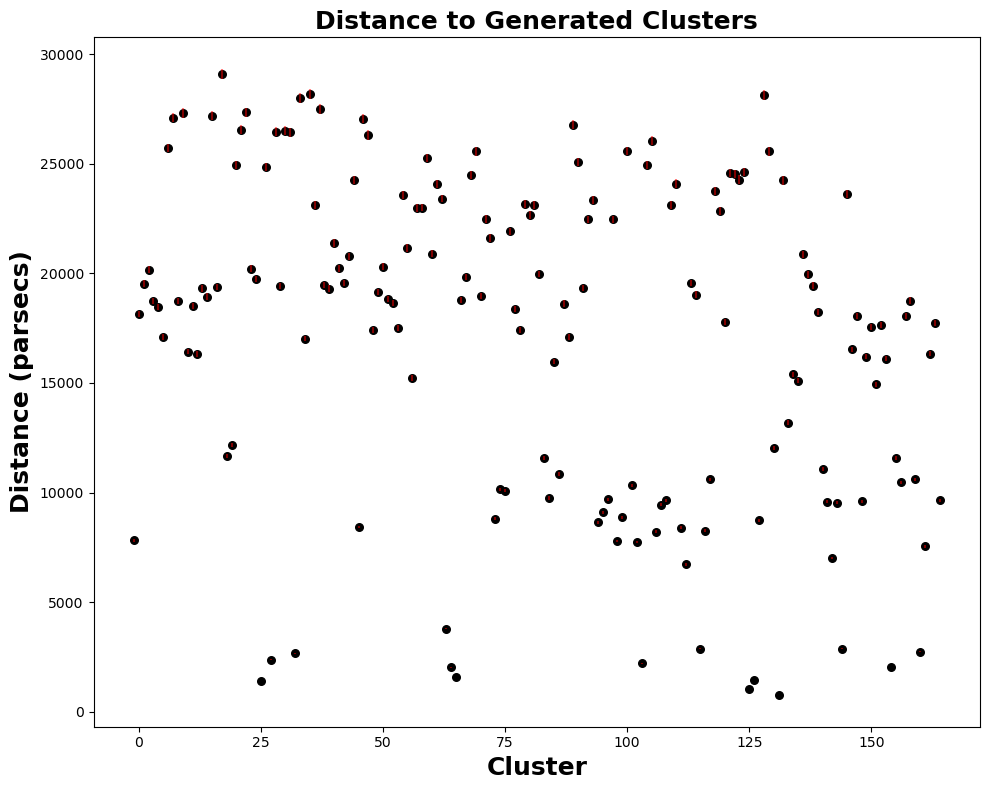

In [31]:
# Plot the distribution of distances for each cluster
plt.figure(figsize=(10, 8))
plt.scatter(cluster_distances_df['Cluster'], cluster_distances_df['Distance (parsecs)'], s=30, color='black')
plt.errorbar(cluster_distances_df['Cluster'], cluster_distances_df['Distance (parsecs)'], yerr=cluster_distance_uncertainties_df['Distance Uncertainty (parsecs)'], fmt='none', ecolor='red', alpha=0.5)
plt.xlabel('Cluster', fontsize=18, fontweight='bold')
plt.ylabel('Distance (parsecs)', fontsize=18, fontweight='bold')
plt.title('Distance to Generated Clusters', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()